# Forecasting Exercises
This exercise walks through a SARIMA prediction and forecast similar to the one done on the Mauna Loa CO₂ dataset.<br>
This time we're using a seasonal time series of California Hospitality Industry Employees.

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

In [33]:
# RUN THIS CELL
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX


# for determining (p,q) orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# for ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose     
# for determining ARIMA orders
from pmdarima import auto_arima                              


# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('../Data/HospitalityEmployees.csv',
                     index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


So <tt>df</tt> has 348 records and one column. The data represents the number of employees in thousands of persons as monthly averages from January, 1990 to December 2018.

### 1. Plot the source data
Create a line chart of the dataset. Optional: add a title and y-axis label.

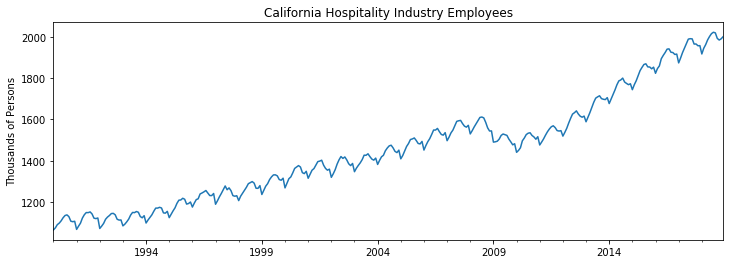

In [34]:
title = 'California Hospitality Industry Employees'
ylabel = 'Thousands of Persons'
xlabel = ''

ax = df['Employees'].plot(figsize=(12,4), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 2. Run an ETS Decomposition
Use an 'additive' model.

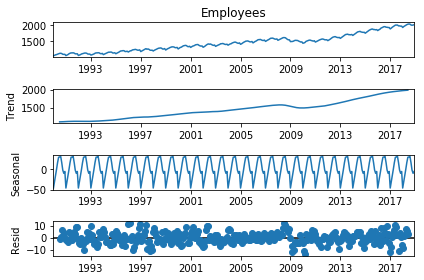

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Employees'], model='additive')
result.plot();

### 3. Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [36]:
auto_arima(df['Employees'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.306
Date:                              Wed, 03 Jun 2020   AIC                           2210.613
Time:                                      22:11:47   BIC                           2237.558
Sample:                                           0   HQIC                          2221.341
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.005      0.080      0.936      -0.010       0.011
ar.L1          0.9231      0.045     20.374      0.000       0.834       1.012
ma.L1         -0.9454      0.071    -13.380      0.000      -1.084      -0.807
ma.L2          0.1323      0.060      2.195      0.028       0.014       0.250
ar.S.L12       0.9977      0.001    721.886      0.000       0.995       1.000
ma.S.L12      -0.7577      0.042    -17.910      0.000      -0.841      -0.675
sigma2        29.2207      1.706     17.133      0.000      25.878      32.564
===================================================================================
Ljung-Box (Q):                       32.09   Jarque-Bera (JB):                66.44
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.09
Prob(H) (two-sided):                  0.45   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

You should see a recommended ARIMA Order of (1, 1, 2) combined with a seasonal order of (1, 0, [1], 12).
### 4. Split the data into train/test sets
Set one year (12 records) for testing. There is more than one way to do this!

In [37]:
len(df)-12

336

In [38]:
# Set four weeks for testing
train = df.iloc[:336]
test = df.iloc[336:]

### 5. Fit a SARIMA(0,1,0)(2,0,0,12) model to the training set

In [41]:
# SARIMAX(1, 1, 2)x(1, 0, [1], 12)
model = SARIMAX(train['Employees'],order=(1,1,2),
    seasonal_order=(1,0,1,12),enforce_invertibility=False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Wed, 03 Jun 2020   AIC                           2128.116
Time:                                      22:12:27   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9241      0.044     21.194      0.000       0.839       1.010
ma.L1         -1.5089      0.237     -6.353      0.000      -1.974      -1.043
ma.L2          0.2578      0.149      1.729      0.084      -0.034       0.550
ar.S.L12       0.9973      0.001    729.249      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.163      0.000      -0.838      -0.666
sigma2        16.7002      4.360      3.830      0.000       8.155      25.245
===================================================================================
Ljung-Box (Q):                       29.89   Jarque-Bera (JB):                73.32
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Obtain predicted values

In [47]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1


# typ='levels' will predict in the original term
# No need to transform back the prediction from differenced scale
predictions = results.predict(start=start, end=end, typ='levels',
    dynamic=False).rename('SARIMA(1,1,2)(1,0,1,12) Predictions')

### 7. Plot predictions against known values
Optional: add a title and y-axis label.

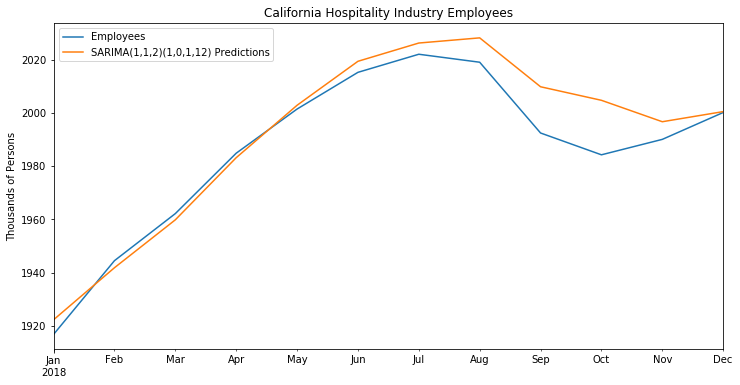

In [48]:
# Plot predictions against known values
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = test['Employees'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 8. Evaluate the Model using MSE and RMSE
You can run both from the same cell if you want.

In [49]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['Employees'], predictions)
error2 = rmse(test['Employees'], predictions)

print(f'SARIMA(1,1,2)(1,0,1,12) MSE Error: {error1:11.10}')
print(f'SARIMA(1,1,2)(1,0,1,12) RMSE Error: {error2:11.10}')
print(f"Mean value of test[Employees]: {test['Employees'].mean():11.10}")

SARIMA(1,1,2)(1,0,1,12) MSE Error: 77.68008299
SARIMA(1,1,2)(1,0,1,12) RMSE Error: 8.813630523
Mean value of test[Employees]:    1986.125


**So error rate is pretty low**

### 9. Retrain the model on the full data and forecast one year into the future

In [50]:
# SARIMAX(1, 1, 2)x(1, 0, [1], 12)
model = SARIMAX(df['Employees'],order=(1,1,2),
    seasonal_order=(1,0,1,12),enforce_invertibility=False)

results = model.fit()

fcast = results.predict(len(df),len(df)+11,typ='levels').\
                    rename('SARIMA(1,1,2)(1,0,1,12) Forecast')

### 10. Plot the forecasted values alongside the original data
Optional: add a title and y-axis label.

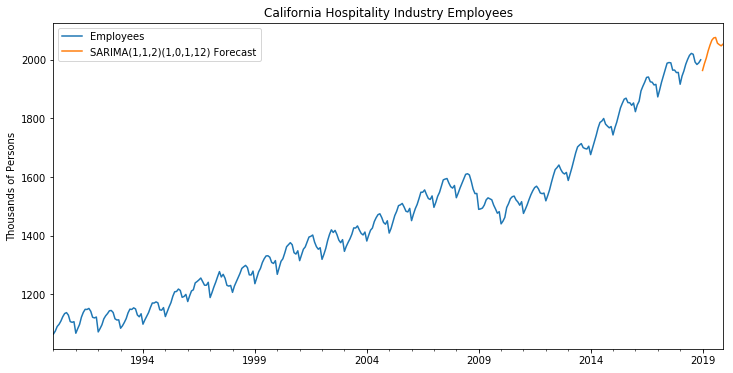

In [51]:
# Plot predictions against known values
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,figsize=(12,6),
                                                 title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);